In [109]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from brainspace.utils.parcellation import map_to_labels, reduce_by_labels
from neuromaps.datasets import fetch_fslr
from surfplot import Plot
from brainspace.datasets import load_parcellation
import plotly.express as px
import os
import modeling_utils as mu

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [21]:
schaefer_labels = load_parcellation('schaefer', scale=1000, join=True)


In [22]:
scz_path = 'clean_data/SCZ/schaefer1000'
controls_path = 'clean_data/controls/schaefer1000'

In [36]:
n_neighbours_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120]


In [ ]:
regions = np.arange(1, 1001)
np.savetxt("schaefer1000_regions.txt", regions, fmt = '%.0f')

In [38]:
scz_group_grads = np.load(f'{scz_path}/aligned_schz_group_10grads_schaefer1000.npy')
control_group_grads = np.load(f'{controls_path}/aligned_control_group_10grads_schaefer1000.npy')

## Load & Visualize Permutation Test

In [31]:
results = pd.read_csv('logreg_perm_test_res.csv')
results["Sig"] = False
results.loc[results["p_value"] <= 0.05, ["Sig"]]= True
results["Grad1_SCZ"] = scz_group_grads[:, 0]
results["Grad1_Control"] = control_group_grads[:, 0]
results["Grad2_SCZ"] = scz_group_grads[:, 1]
results["Grad2_Control"] = control_group_grads[:, 1]
results["Grad3_SCZ"] = scz_group_grads[:, 2]
results["Grad3_Control"] = control_group_grads[:, 2]


In [32]:
sig_df = results[results['Sig']].reset_index()

In [33]:
fig1 = px.scatter(results, x="Grad2_SCZ", y="Grad1_SCZ",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=0.08)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         showbackground=True,
                         backgroundcolor='white',
                         gridcolor="rgb(220, 220, 220)",
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False),
                    yaxis=dict(
                        showbackground=True,
                        backgroundcolor='white',
                        gridcolor="rgb(220, 220, 220)",
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False)),
                    width=700,
                    height=500,
                    margin=dict(r=10, l=10, b=10, t=10))

fig2 = px.scatter(sig_df, x="Grad2_SCZ", y="Grad1_SCZ",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=1.0)
fig1.add_trace(fig2.data[0])
fig1.show()


In [34]:
fig1 = px.scatter(results, x="Grad2_Control", y="Grad1_Control",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=0.08)

fig1.update_layout(scene=dict(
                    xaxis=dict(
                         showbackground=True,
                         backgroundcolor='white',
                         gridcolor="rgb(220, 220, 220)",
                         zerolinecolor="white",
                         title="Gradient 2",
                         showticklabels=False),
                    yaxis=dict(
                        showbackground=True,
                        backgroundcolor='white',
                        gridcolor="rgb(220, 220, 220)",
                        zerolinecolor="white",
                        title="Gradient 1",
                        showticklabels=False)),
                    width=700,
                    height=500,
                    margin=dict(r=10, l=10, b=10, t=10))

fig2 = px.scatter(sig_df, x="Grad2_Control", y="Grad1_Control",
                  color='beta',template = "plotly_white", color_continuous_scale='Bluered', opacity=1.0)
fig1.add_trace(fig2.data[0])
fig1.show()

## Plot results on control 1st grad

In [35]:
sig_regions = results["Sig"].values

In [36]:
sig_region_effect = np.zeros((1000))
sig_region_effect[:] = np.nan
sig_region_effect[sig_regions == True]  = results["beta"].values[sig_regions == True]

In [37]:
results["beta"].values[sig_regions == True]

array([ 0.0383942 ,  0.00340695,  0.06374755, -0.04501805, -0.13135384,
       -0.03777134,  0.10963997, -0.14771635, -0.00614462, -0.38193085,
        0.09344675,  0.05582711, -0.04847695, -0.0895011 ,  0.14369879,
       -0.16801373, -0.19851753, -0.03097096, -0.01401264,  0.07944625,
       -0.13681568, -0.08712567, -0.15246304,  0.05453908, -0.07302381,
       -0.03585372,  0.03584319, -0.15945309, -0.28523935, -0.13340846,
        0.0075728 ,  0.2756622 , -0.21012307, -0.03597933])

In [38]:
sig_regions_vis = map_to_labels(sig_regions, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)
sig_region_effect_vis = map_to_labels(sig_region_effect, schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

In [39]:
control_1grad_aligned_vis = map_to_labels(control_group_grads[:, 0], schaefer_labels, mask=schaefer_labels != 0, fill=np.nan)

In [40]:
surfaces = fetch_fslr()
lh, rh = surfaces['inflated']
lh_parc, rh_parc = load_parcellation('schaefer')

In [41]:
np.unique(sig_region_effect_vis*100)

array([-38.193085  , -28.52393538, -21.01230676, -19.85175308,
       -16.80137278, -15.94530933, -15.24630354, -14.77163457,
       -13.68156835, -13.34084619, -13.13538436,  -8.95010986,
        -8.71256666,  -7.30238121,  -4.84769514,  -4.50180474,
        -3.77713414,  -3.58537202,  -3.09709559,  -1.40126432,
        -0.61446245,   0.34069504,   0.75728011,   3.5843185 ,
         3.83942023,   5.45390771,   5.58271103,   6.37475461,
         7.94462463,   9.34467495,  10.96399736,  14.36987874,
        27.56622007,          nan])

/var/folders/2m/72fcyjmd7vs3g18rkfwx7nw40000gn/T/ipykernel_4032/3150529044.py:7: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



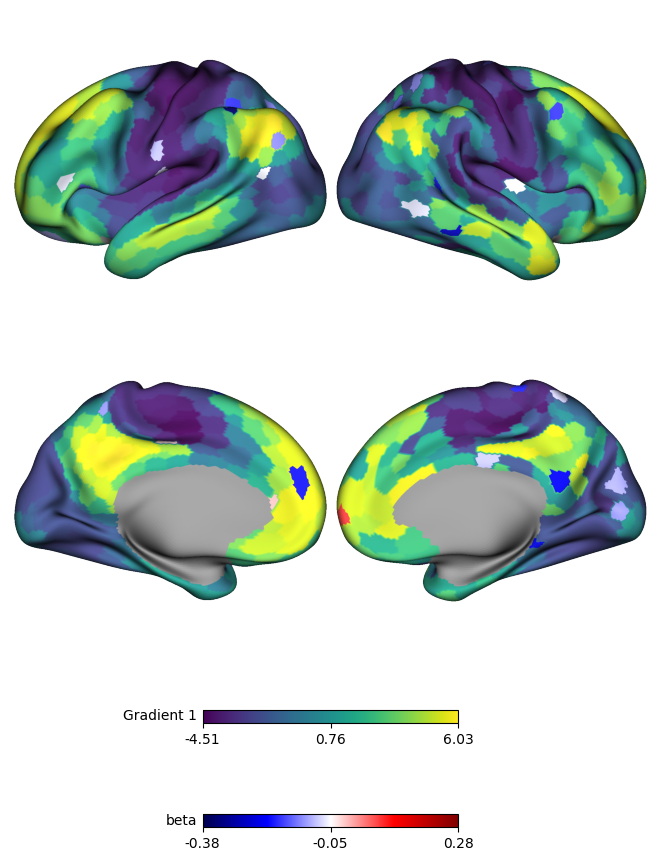

In [42]:
result_coefs = Plot(lh, rh,  size=(1000, 1000), zoom = 1.25)

result_coefs.add_layer({'left': control_1grad_aligned_vis[:32492], 'right': control_1grad_aligned_vis[32492:]}, cbar=True, cmap = "viridis", cbar_label= "Gradient 1")
result_coefs.add_layer({'left': sig_region_effect_vis[:32492]*10, 'right': sig_region_effect_vis[32492:]*10}, as_outline= False, cmap='seismic', cbar=True, cbar_label="beta", color_range = (np.nanmin(sig_region_effect_vis), np.nanmax(sig_region_effect_vis)))

fig = result_coefs.build(scale = (2, 2))
fig.show()
#result_t.show(embed_nb = True, scale=(10, 10))